## О задании

В этом задании мы подготовим данные и выполним EDA (Exploratory Data Analysis), с помощью инструментов: numpy, pandas, matplotlib, seaborn и plotly. Это учебный проект, поэтому не все выдвинутые гипотезы предложены мной.

EDA - важный этап работы с данными. Именно в процессе EDA мы можем выяснить особенности датасета, найти зависимости в данных, протестировать гипотезы о взаимосвязях признаков и целевой переменной.




## О данных

Будем работать с [датасетом физической активности](https://www.kaggle.com/datasets/uciml/human-activity-recognition-with-smartphones).

В этом датасете собраны данные 30 человек, выполняющих различные действия со смартфоном на поясе. Данные записывались с помощью датчиков (акселерометра и гироскопа) в этом смартфоне. Были зафиксированы: "3-осевое линейное ускорение" (_tAcc-XYZ_) и "3-осевая угловая скорость" (_tGyro-XYZ_).

1. Все сигналы отсортированы по времени, пропущены через фильтр шума.
2. Все наблюдения были разделены на окна по 128 сигналов в каждом, причем окна пересекаются на 50% (грубо говоря, с 1 по 128 сигнал в 1 окно, с 64 до 192 сигнала - во 2 окно и так далее).
3. Линейное ускорение было разделено на две составляющие (с помощью низкочастотного фильтра): ускорение самого тела, а также гравитационная составляющая. Будем называть их ускорением тела и гравитационным ускорением.
4. К получившимся окнам применяли различные функции для получения следующих показателей:
    - max
    - min
    - mad (median)
    - mean
    - std
    - skewness (коэффициент асимметричности распределения признака в окне)
    - etc. (подробнее, на сколько это возможно, указано на [страничке датасета](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones))
5. Величина (magnitude) сигнала также определялась через евклидову норму всех значений из вектора для одного окна.
6. К окнам было применено преобразование Фурье, чтобы получить частоты. Из частот были извелченыте же показатели, плюс новые:
    - bandsEnergy (энергия частотного интервала)
7. Были посчитаны углы между векторами соответствующих окон.
8. Для ускорений были посчитаны производные - рывки, к которым применялись те же функции.

Итог: в датасете каждый признак - это какая-то операция над вектором из 128 чисел, которые соответствуют замерам определенного человека занятого какой-то активностью на протяжении 2.56 секунд.

Как читать названия признаков? Примеры:
- `tBodyAccMag-mean()` - это вектор ускорений тела (без гравитационной составляющей этого ускорения), из которого взяли евклидову норму, а затем усреднили, чтобы получить скаляр
- `fBodyAcc-bandsEnergy()-1,8.2` - это вектор ускорения тела, к которому применили преобразование Фурье, преобразовав его в вектор частот, а затем посчитали на этом векторе энергию данного частотного интервала в определенном диапазоне частот (в данном случае 1 - 8.2)
- `angle(X,gravityMean)` - это угол между осью Х и вектором усредненных значений гравитационного ускорения из соответствующего окна



## Предобработка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv("test.csv")

In [ ]:
train.shape

(7352, 563)

В датасете 563 признака, включая целевую переменную. Столько признаков нам не нужно. Мы сделали подвыборку признаков для удобства работы с ними.

In [ ]:
cols_subset = [
    'tBodyAccMag-mean()',  # усредненная величина ускорения тела
    'tBodyGyroJerk-mad()-X',  # медианная величина рывка тела по оси Х
    'tGravityAcc-min()-X',  # минимум гравитационной составляющей ускорения по оси Х
    'tBodyAcc-max()-X',  # максимальная величина ускорения тела по оси Х
    'fBodyAcc-bandsEnergy()-1,8.2',  # энергия ускорения тела в интервале частоты
    'angle(X,gravityMean)',  # угол между осью Х и усредненной гравитационной составляющей ускорения
    'angle(Y,gravityMean)',  # угол между осью Y и усредненной гравитационной составляющей ускорения
    'angle(Z,gravityMean)',  # угол между осью Z и усредненной гравитационной составляющей ускорения,
    'fBodyAcc-skewness()-X',  # асимметричность частоты ускорения тела по оси Х
    'subject',  # номер испытуемого
    'Activity',  # название вида деятельности (целевая переменная)
]

In [ ]:
train = train[cols_subset]
test = test[cols_subset]

In [ ]:
train.head()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject,Activity
0,-0.959434,-0.992165,0.977436,-0.934724,-0.993592,-0.841247,0.179941,-0.058627,0.142051,1,STANDING
1,-0.979289,-0.989876,0.984520,-0.943068,-0.998235,-0.844788,0.180289,-0.054317,-0.692541,1,STANDING
2,-0.983703,-0.987868,0.986770,-0.938692,-0.999388,-0.848933,0.180637,-0.049118,-0.727227,1,STANDING
3,-0.986542,-0.991241,0.986821,-0.938692,-0.999807,-0.848649,0.181935,-0.047663,-0.599118,1,STANDING
4,-0.992827,-0.992882,0.987434,-0.942469,-0.999806,-0.847865,0.185151,-0.043892,-0.676997,1,STANDING


### 1 этап

Посмотрим на пропуски и дубли в данных train и test.


In [ ]:
train.isnull().sum()

tBodyAccMag-mean()              0
tBodyGyroJerk-mad()-X           0
tGravityAcc-min()-X             0
tBodyAcc-max()-X                0
fBodyAcc-bandsEnergy()-1,8.2    0
angle(X,gravityMean)            0
angle(Y,gravityMean)            0
angle(Z,gravityMean)            0
fBodyAcc-skewness()-X           0
subject                         0
Activity                        0
dtype: int64

In [ ]:
test.isnull().sum()

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64

In [ ]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tBodyAccMag-mean()            7352 non-null   float64
 1   tBodyGyroJerk-mad()-X         7352 non-null   float64
 2   tGravityAcc-min()-X           7352 non-null   float64
 3   tBodyAcc-max()-X              7352 non-null   float64
 4   fBodyAcc-bandsEnergy()-1,8.2  7352 non-null   float64
 5   angle(X,gravityMean)          7352 non-null   float64
 6   angle(Y,gravityMean)          7352 non-null   float64
 7   angle(Z,gravityMean)          7352 non-null   float64
 8   fBodyAcc-skewness()-X         7352 non-null   float64
 9   subject                       7352 non-null   int64  
 10  Activity                      7352 non-null   object 
dtypes: float64(9), int64(1), object(1)
memory usage: 631.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries

In [ ]:
train.duplicated().sum()


0

In [ ]:
test.duplicated().sum()

0

По итогу, пропусков и  дублей - нет


### Шаг 2

Выводим основные статистики данных: среднее, медиана, перцентили (0.25, 0.5, 0.75), минимум, максимум, стандартное отклонение.


In [ ]:
train.describe()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,-0.543884,-0.727735,0.678505,-0.468604,-0.847963,-0.489547,0.058593,-0.056515,-0.128562,17.413085
std,0.477653,0.315832,0.508656,0.544547,0.233633,0.511807,0.297480,0.279122,0.403686,8.975143
min,-1.000000,-0.999889,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.931208,1.000000
25%,-0.983282,-0.991595,0.804270,-0.936219,-0.999480,-0.812065,-0.017885,-0.143414,-0.486841,8.000000
50%,-0.883371,-0.950268,0.926693,-0.881637,-0.986582,-0.709417,0.182071,0.003181,-0.163271,19.000000
75%,-0.106892,-0.474625,0.965095,-0.017129,-0.764508,-0.509079,0.248353,0.107659,0.155112,26.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.478157,1.000000,1.000000,30.000000


In [ ]:
test.describe()

,tBodyAccMag-mean(),tBodyGyroJerk-mad()-X,tGravityAcc-min()-X,tBodyAcc-max()-X,"fBodyAcc-bandsEnergy()-1,8.2","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",fBodyAcc-skewness()-X,subject
count,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000,2947.000000
mean,-0.559043,-0.735661,0.696878,-0.462063,-0.880361,-0.513923,0.074886,-0.048720,-0.154042,12.986427
std,0.439539,0.282074,0.502873,0.523916,0.160496,0.509205,0.324300,0.241467,0.392203,6.950984
min,-0.998936,-1.000000,-0.756774,-0.952357,-0.999989,-0.984195,-0.913704,-0.949228,-1.000000,2.000000
25%,-0.978433,-0.989078,0.836787,-0.934447,-0.999330,-0.829722,0.022140,-0.098485,-0.497070,9.000000
50%,-0.861830,-0.914698,0.934930,-0.852659,-0.979336,-0.729648,0.181563,-0.010671,-0.202050,12.000000
75%,-0.149596,-0.486423,0.970871,-0.009965,-0.799113,-0.545939,0.260252,0.092373,0.140254,18.000000
max,0.479547,0.117606,0.996148,0.786436,0.048730,0.833180,1.000000,0.973113,0.960367,24.000000


Медиана это тоже самое, что перцентиль 0,5

### Шаг 3

Данные сбалансированы? У нас есть 6 категорий активности (целевая переменная). Если одна из категорий представлена большим количеством наблюдений, а остальные - нет, то это обстоятельство, о котором хотелось бы знать заранее.

Выведем количество наблюдений для всех категорий активности в train и test. Посчитаем разницу в процентах между самой крупной категорией и самой маленькой (самая большая категория - это 100%).


In [ ]:
train['Activity'].value_counts()

LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [ ]:
columt1max = train['Activity'].value_counts().idxmax()
columt1min = train['Activity'].value_counts().idxmin()
(train['Activity'].value_counts()[columt1max]-train['Activity'].value_counts()[columt1min])/train['Activity'].value_counts()[columt1max]

0.2992181947405828

In [ ]:
test['Activity'].value_counts()

LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64

In [ ]:
columt2max = test['Activity'].value_counts().idxmax()
columt2min = test['Activity'].value_counts().idxmin()
(test['Activity'].value_counts()[columt2max]-test['Activity'].value_counts()[columt2min])/test['Activity'].value_counts()[columt2max]

0.21787709497206703

разница небольшая тк не превышает 30, то данные сбалансированы



### Шаг 4

Посчитаем корреляцию всех признаков (включая таргет) со всеми другими.

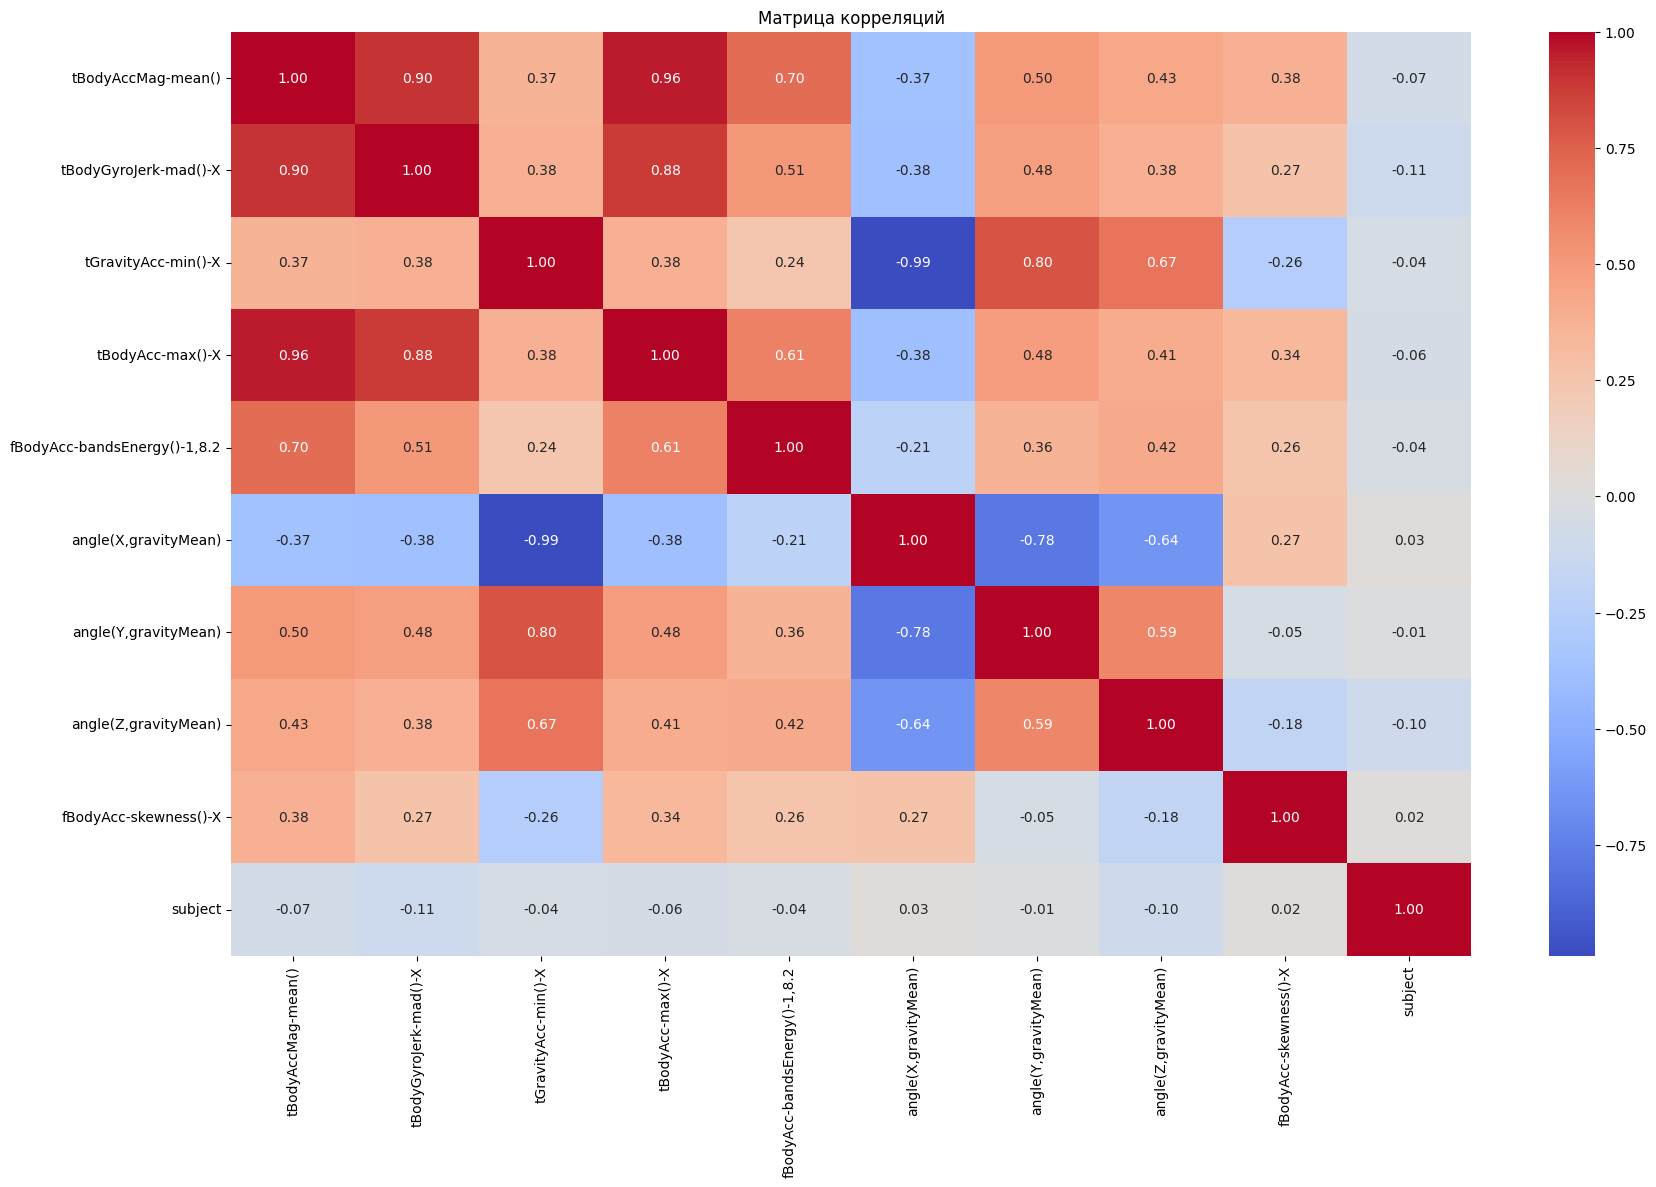

In [ ]:
plt.figure(figsize=(20, 12))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Матрица корреляций')
plt.show()

Можно заметить отсутствие корреляции между subject и другими столбцами, это происходит, так как во всех категориях активности ускорение тела и гравитационная составляющая везде примерно одинаковая

Поздравляем! Вы предобработали данные для максимально комфортного их последующего анализа. Теперь вы готовы приступить к Exploratory Data Analysis!

## Exploratory Data Analysis

### Шаг 5

Ранее мы уже проверили сбалансированность данных по разным категориям активностей в train и test сетах. Теперь визуализируем количество сэмплов в каждой из категорий отдельно для train и test сетов.
Используем:
- plt.barh или ax.barh

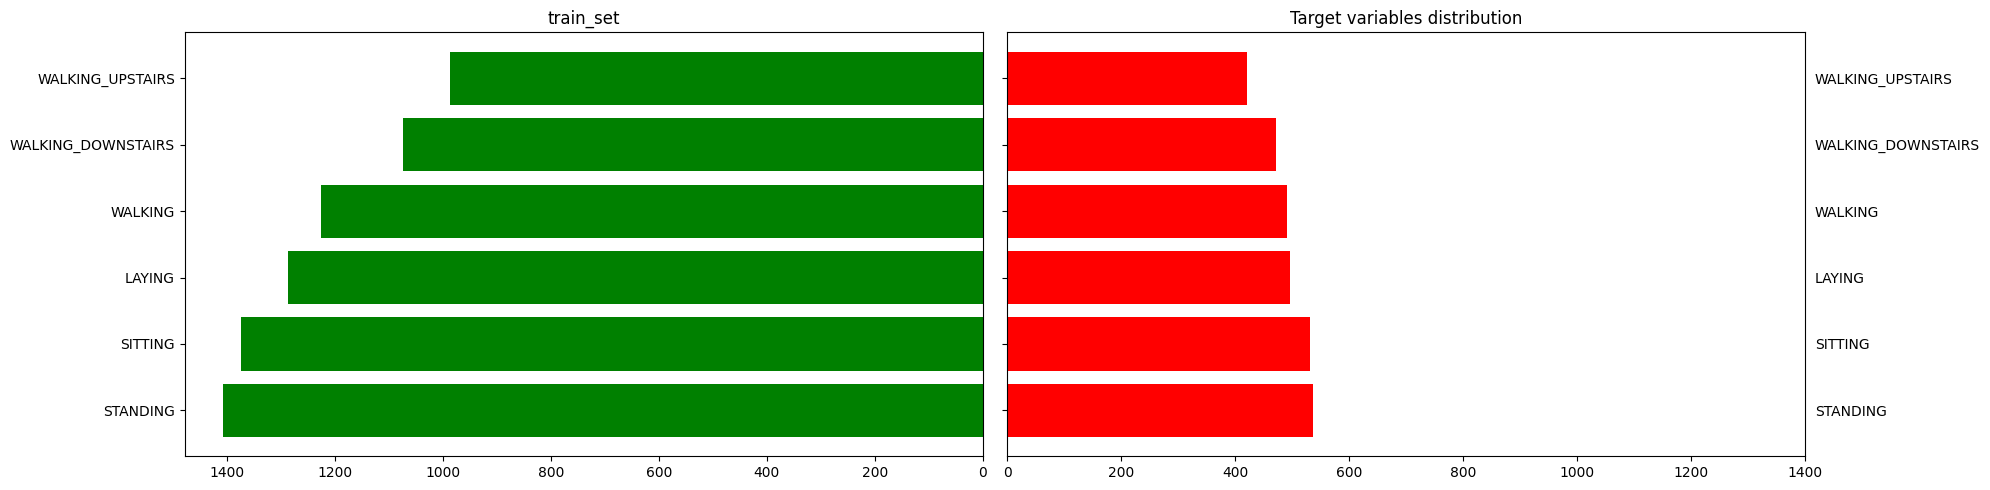

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax1.barh(train['Activity'].unique(), train['Activity'].value_counts(), color='green')
ax1.set_title('train_set')
ax2.barh(test['Activity'].unique(), test['Activity'].value_counts(), color='red')
ax2.set_title('test_set')
ax1.invert_xaxis()
plt.title('Target variables distribution')
plt.tick_params(axis='y', labelright=True, labelleft=False)
plt.tight_layout()
plt.xlim(0, 1400)
plt.show()

### Шаг 6

Сделаем более читаемую таблицу корреляций.

Используем:
- sns.heatmap
- методы get_text и set_text у атрибута texts графика

In [1]:
plt.figure(figsize=(20, 12))
ax = sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
for t in ax.texts:
    if abs(float(t.get_text())) >= 0.5:
        t.set_text(t.get_text())
    else:
        t.set_text("")
plt.title('Матрица корреляций', fontsize=26)
plt.show()

NameError: name 'plt' is not defined

fBodyAcc-skewness()-X лишний, тк он  корреляция с другими признакми меньше 0.5 по модулю

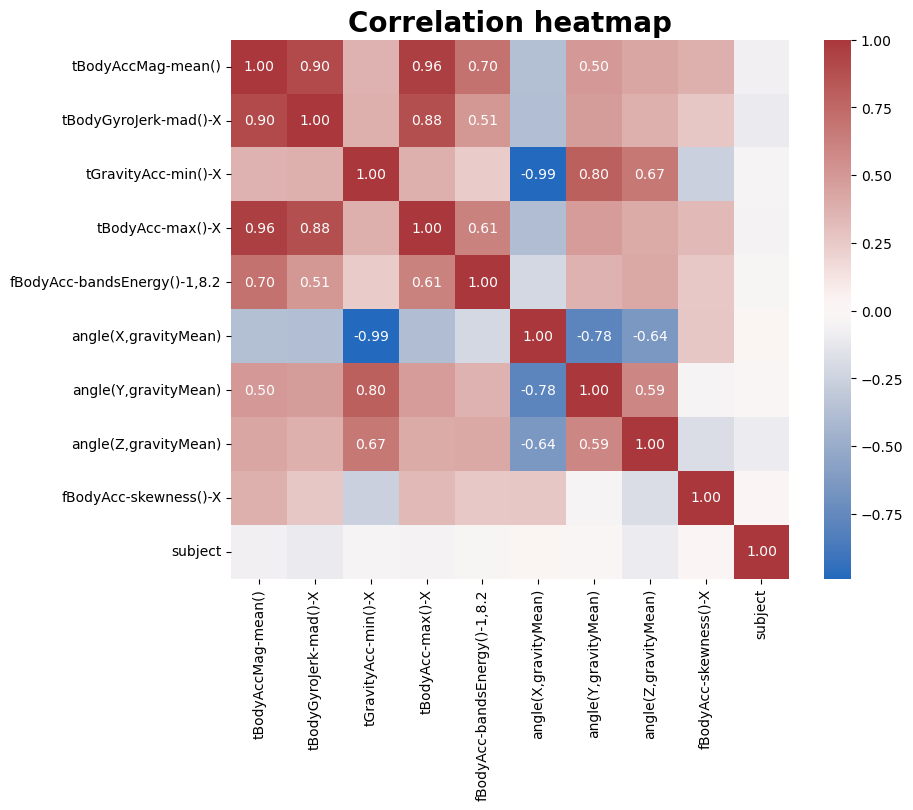

### Шаг 7


Попробуем проверить гипотезу. Отобразим плотность распределения (kde) `tBodyAccMag-mean()` для каждой из активностей, как в примере ниже. Разделим на 2 группы.

Давайте первую группу называть статическими активностями, а вторую - динамическими.

Посчитаем, какую долю правильных ответов дает ваша вертикальная линия для разделения именно этих двух групп.

Используем:
- sns.kdeplot

0.4912948857453754
0.5087051142546246


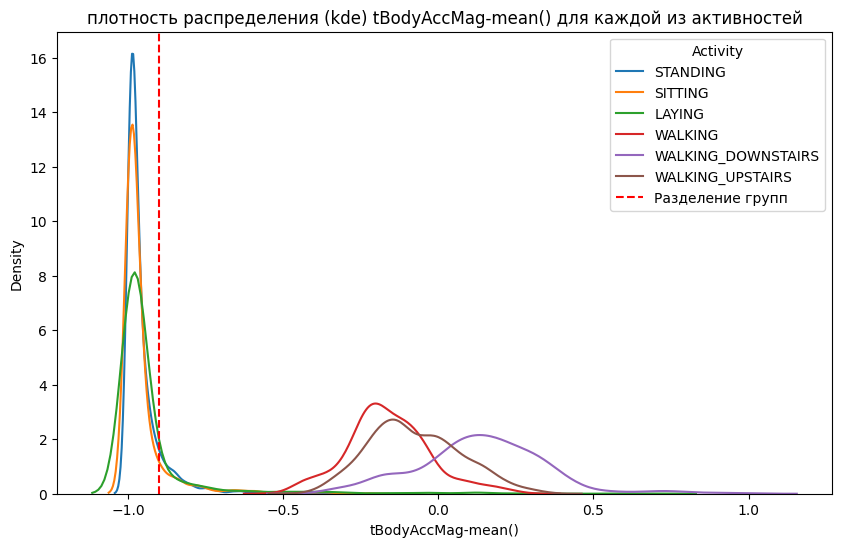

In [ ]:
plt.figure(figsize=(10, 6))
for i in train['Activity'].unique():
    sns.kdeplot(train[train['Activity'] == i]['tBodyAccMag-mean()'], label=i)

#задаю переменную, чтобы посмотреть как меняется результат
line = -0.9
plt.axvline(x=line, color='red', linestyle='--', label='Разделение групп')
plt.title('плотность распределения (kde) tBodyAccMag-mean() для каждой из активностей')
plt.legend(title='Activity')


static = train[train['tBodyAccMag-mean()'] <= line]['Activity']
dynamic = train[train['tBodyAccMag-mean()'] > line]['Activity']
#доли ответов сначало левой потом правой
print(len(static)/ len(train))
print(len(dynamic) / len(train))
plt.show()

### Шаг 8

Давайте будем исактьхарактерные черты каждого отдельного вида активности. Попробуем нарисовать "ящики с усами" для `angle(X,gravityMean)` с разделением по разным видам активности на данных train.

Используем:
- sns.boxplot

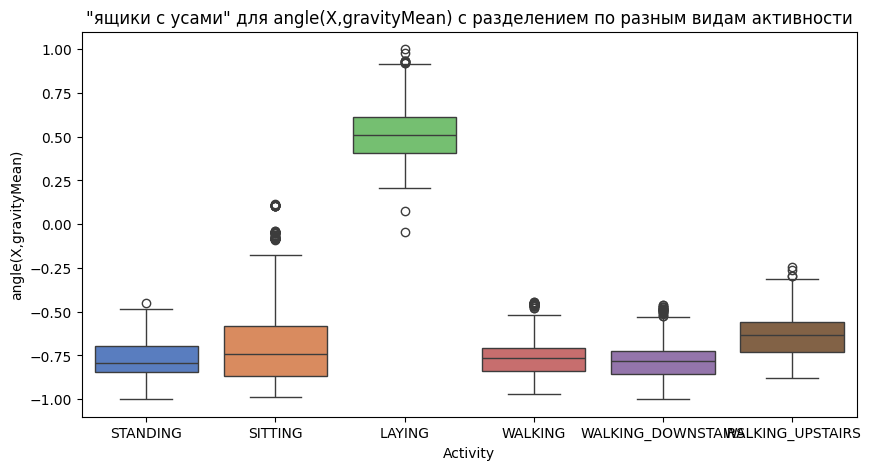

In [ ]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='Activity', y='angle(X,gravityMean)', data=train, palette='muted')
plt.title('"ящики с усами" для angle(X,gravityMean) с разделением по разным видам активности')
plt.show()

из графика видно, что когда челове лежит, угол между осью Х и гравитационной составляющей ускорения положительно. Так получается, потому что в других положениях люди расположены вертикально, а когда человек лкжит, он распл горизонтально

### Шаг 9

Посмотрим теперь на `tBodyAcc-max()-X`. Визуализируем скрипичные диаграммы для этого признака с разделением по активностям на всем train.

Используем:
- sns.violinplot

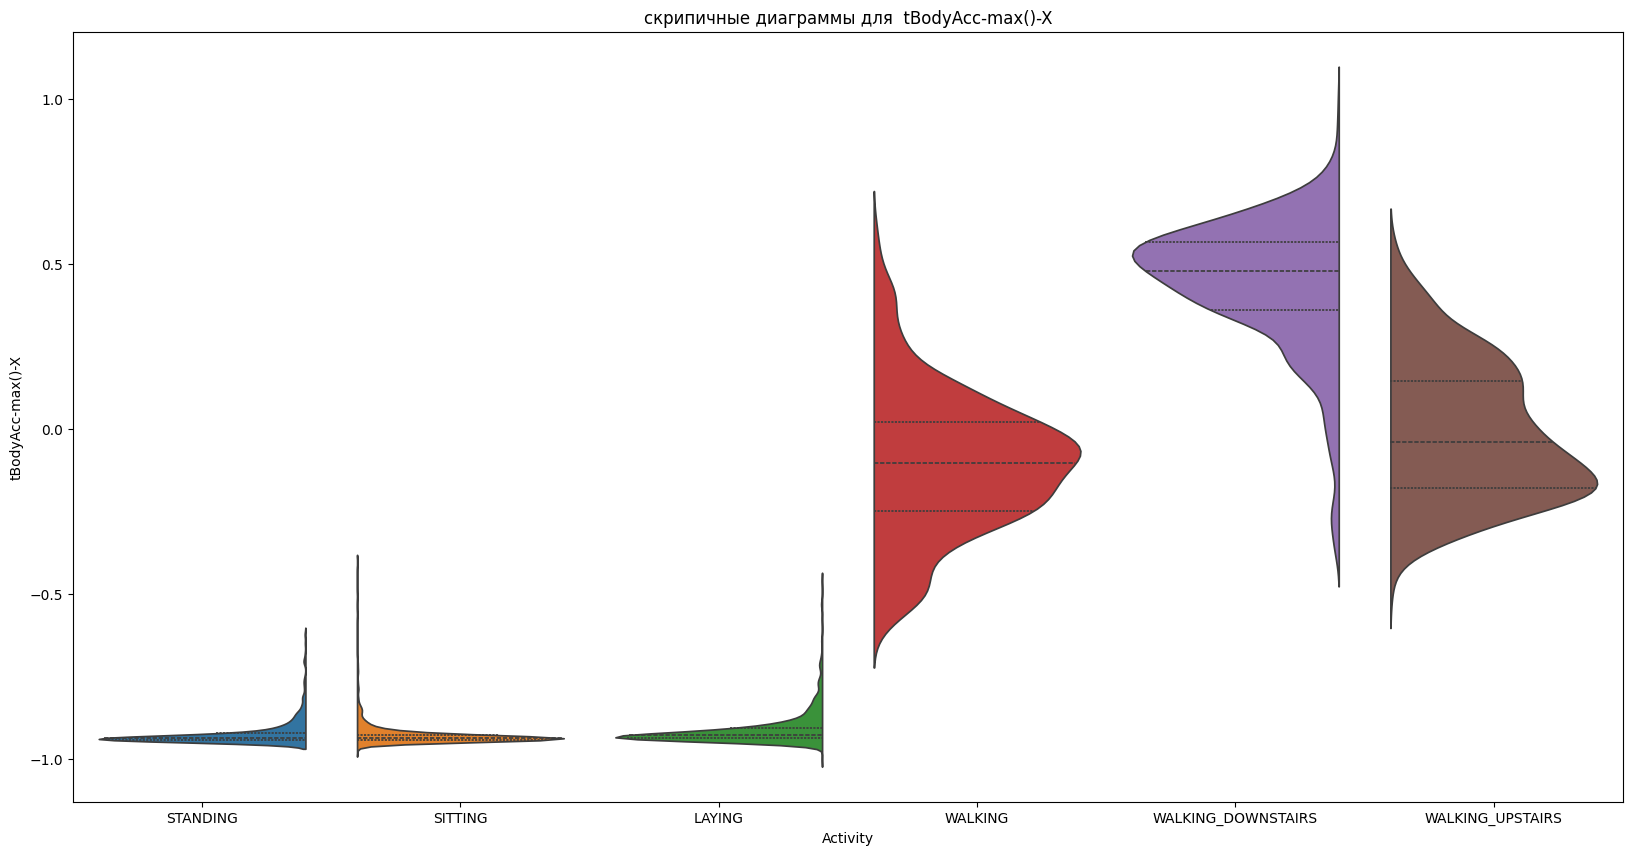

In [ ]:
plt.figure(figsize=(20, 10))
sns.violinplot(data=train,x='Activity', y='tBodyAcc-max()-X',hue="Activity", split=True, inner="quart")
plt.title('скрипичные диаграммы для  tBodyAcc-max()-X')
plt.show()

очень выделяющихся активностей нет, но можно заметить 2 группые:
1) это ходьба, разница рывков большая, тк все время двигаешься с разным ускорением
2) это лежать или стоять или сидеть рывки там отрицательные тк положение статичное

### Шаг 10

Мы уже можем с довольно хорошим качеством выделить две категории активности из шести. Продолжим.

Ранее уже упоминалось разделение на две группы активностей: статические и динамические. Пришла пора разделить датасет train на две части. Теперь на одной картинке покажем распределения `fBodyAcc-bandsEnergy()-1,8.2` для динамичных активностей (boxenplot - немного измененый "ящик с усами") и `angle(Y,gravityMean)` для статических.

Используем:
- plt.subplots или matplotlib.gridspec (заметили, что один график больше другого? попробуйте сами так сделать - вам понравится...)
- sns.boxenplot
- sns.histplot

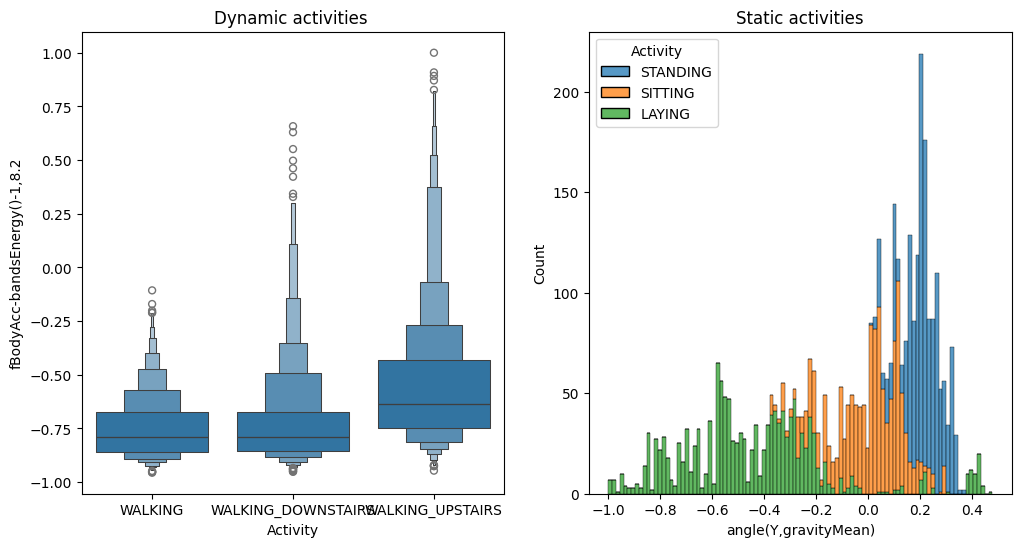

In [ ]:

dynamic_data = train[train['Activity'].isin(['WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS'])]
static_data = train[train['Activity'].isin(['STANDING', 'SITTING', 'LAYING'])]


fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxenplot(data=dynamic_data, x = dynamic_data['Activity'], y = dynamic_data['fBodyAcc-bandsEnergy()-1,8.2'], ax=axes[0])
axes[0].set_title('Dynamic activities ')

sns.histplot(data=static_data, x = static_data['angle(Y,gravityMean)'],hue='Activity', ax=axes[1],  bins=100, multiple="stack")
axes[1].set_title('Static activities')
plt.show()

Выделяем Standing и Walking Upstairs


### Шаг 11

Рассмотрим только статические активности. Будет снова два графика сразу. На первом графике будет боксплот распределения `fBodyAcc-skewness()-X` по активностям. А на втором попробуем взять не все наблюдения данной группы активностей, а только их часть.

Используем:
- plt.subplots или matplotlib.gridspec
- sns.boxplot

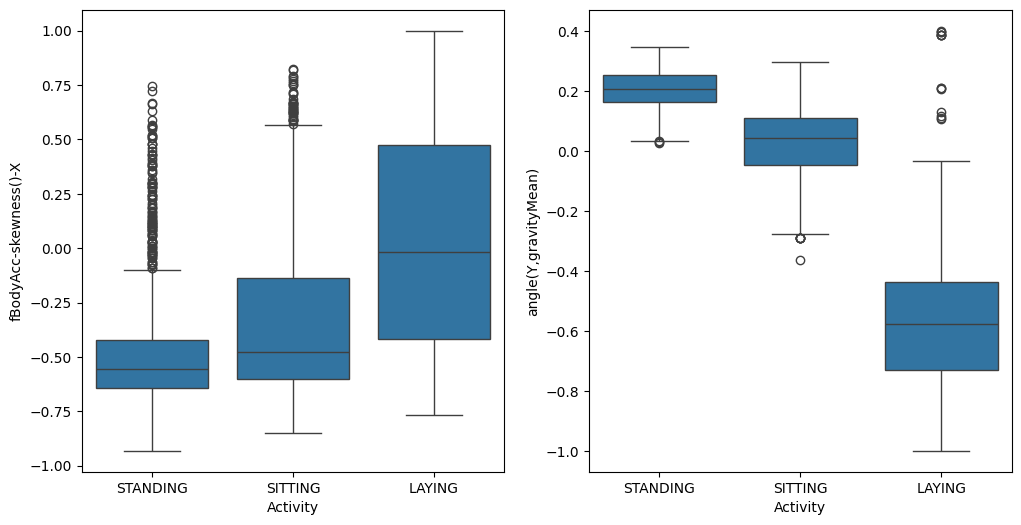

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(x='Activity', y='fBodyAcc-skewness()-X', data=static_data, ax=axes[0])

filtered_static_data = static_data[static_data['fBodyAcc-skewness()-X'] < -0.376]

sns.boxplot(x='Activity', y='angle(Y,gravityMean)', data=filtered_static_data, ax=axes[1])


plt.show()

Поздравляем, теперь вы на шажок ближе к тому, чтобы стать решающим деревом!

### Шаг 12

Вот и осталась лишь одна активность, которую мы никак не выделили. Попробуем и ее какими-то порогами отделить от всех остальных. Да, можно было бы сказать, что, раз уж мы выделили 5 из 6 категорий, то все остальное - это и есть последняя категория, но мы не идем легкими путями. Выделить оставшуюсь категорию с хорошим качеством не так уж и просто. Из доступных признаков, сначала посмотрите на распределение `tBodyAcc-max()-X` на динамических активностях (скрипичная диаграмма отлично подойдет).

А теперь спускаем вам порог `tBodyAcc-max()-X < 0.157`. Для таких строк постройте диаграмму рассеяния для признака `tGravityAcc-min()-X`. Да, получается неидеально, но это честная работа. Можно выбрать порог так, чтобы чисто из таблицы с динамическими активностями из строк, где `tBodyAcc-max()-X < 0.157`, выбрать по некоторому порогу для `tGravityAcc-min()-X` строки так, чтобы доля правильных ответов на оставшейся категории была не меньше 83%!

Используем:
- plt.subplots или matplotlib.gridspec
- sns.violinplot
- sns.swarmplot (иногда лучше подходит, чем просто sns.scatterplot)



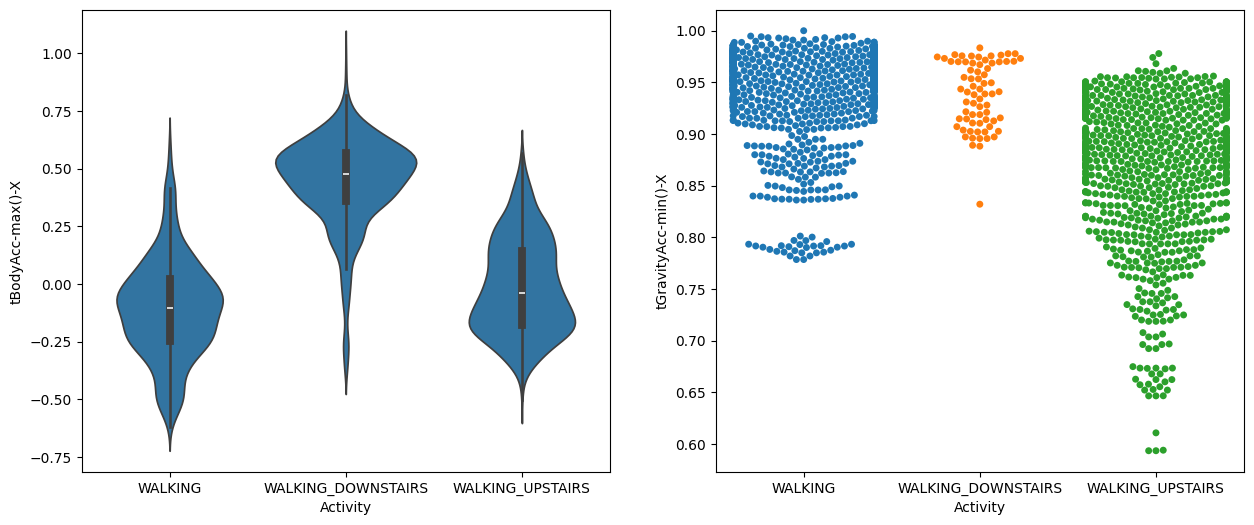

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.violinplot(x='Activity', y='tBodyAcc-max()-X', data=dynamic_data, ax=axes[0])

filt_dynamic_data = dynamic_data[dynamic_data['tBodyAcc-max()-X'] < 0.157]

sns.swarmplot(x = 'Activity', y='tGravityAcc-min()-X', data=filt_dynamic_data, hue='Activity', ax=axes[1])
plt.show()

### Шаг 13

Теперь попробуем более интерактивные графики. Установите библиотеку `plotly` (обычно `pip install plotly` или `conda install plotly`). Синтаксис очень похож на `seaborn`, но вот [документация для plotly.express](https://plotly.com/python-api-reference/plotly.express.html).

Сначала подготовим данные для визуализации. Будем считать t-SNE просто "черным ящиком", который принимает наши данные и проецирует их в двумерное или трехмерное пространство. Возможно, придется немного подождать.

In [ ]:
pip install plotly

In [ ]:
%%time
from sklearn.manifold import TSNE
tsne = TSNE(random_state=666, n_components=2)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_2_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y']),
    train['Activity']
], axis=1)

tsne = TSNE(random_state=666, n_components=3)
new = tsne.fit_transform(train.drop(['subject', 'Activity'], axis=1))
df_3_comp = pd.concat([
    pd.DataFrame(new, columns=['x', 'y', 'z']),
    train['Activity']
], axis=1)

CPU times: user 7min 51s, sys: 1.12 s, total: 7min 52s
Wall time: 4min 47s


Теперь нарисуем scatter-график через `plotly.express` для `df_2_comp` с выделением цветами активностей.

In [ ]:

import plotly.express as px

fig = px.scatter(df_2_comp, x='x', y='y', color='Activity')
fig.show()



### Шаг 14

Сделаем predict.Фукнция `accuracy_score` выдает нам долю правильных ответов.


In [ ]:
def predict(df: pd.DataFrame):
    predictions = []
    for index, row in df.iterrows():
      if row['tBodyAccMag-mean()'] < -0.53:
        if row['angle(X,gravityMean)']>0.11:
          predictions.append('LAYING')

        elif row["fBodyAcc-skewness()-X"] < -0.376 and -0.36 <= row["angle(Y,gravityMean)"] <= 0.14:
          predictions.append('SITTING')
        else:
          predictions.append('STANDING')
      else:
        if row['tBodyAcc-max()-X'] > 0.25:
          predictions.append('WALKING_DOWNSTAIRS')
        elif row['fBodyAcc-bandsEnergy()-1,8.2'] > -0.4 or row['tGravityAcc-min()-X'] < 0.89:
          predictions.append('WALKING_UPSTAIRS')
        else:
          predictions.append('WALKING')
    return np.array(predictions)


def accuracy_score(y_true, y_pred) -> float:
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return (y_true == y_pred).mean()

train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

Accuracy on train set => 0.7808759521218716
Accuracy on test set => 0.7590770274855786


In [ ]:
train_preds = predict(train)
test_preds = predict(test)
print(f"Accuracy on train set => {accuracy_score(train['Activity'], train_preds)}")
print(f"Accuracy on test set => {accuracy_score(test['Activity'], test_preds)}")

NameError: name 'predict' is not defined